# Imports

In [1]:
!pip install -q rectools

     |████████████████████████████████| 89 kB 3.3 MB/s 
     |████████████████████████████████| 310 kB 43.8 MB/s 
     |████████████████████████████████| 13.4 MB 45.8 MB/s 
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 60 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 70.6 MB/s 
     |████████████████████████████████| 188 kB 56.8 MB/s 


In [2]:
import datetime
import numpy as np
import requests
from copy import deepcopy

from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm
from scipy.stats import mode
from pprint import pprint

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(17, 9)})

from IPython.core.display import display, HTML, clear_output
display(HTML('<style>.container { width:80% !important; }</style>'))
display(HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display(HTML('<style>div#notebook { font-size:12px !important; }</style>'))

import warnings
warnings.filterwarnings("ignore")

from rectools import Columns
from rectools.dataset import Dataset, Interactions

# Get KION dataset 

<a href="https://ods.ai/competitions/competition-recsys-21/data"> Dataset description [ru] </a>


In [3]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [4]:
import zipfile as zf

files = zf.ZipFile('kion.zip', 'r')
files.extractall()
files.close()

In [5]:
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')
interactions = pd.read_csv('kion_train/interactions.csv', parse_dates=['last_watch_dt'])

# Preprocessing
Копипаст основного кода из [доступного ноутбука в сореве](https://ods.ai/competitions/competition-recsys-21/data)

## Users

In [6]:
users['age'] = users['age'].fillna('age_unknown')
users['age'] = users['age'].astype('category')

In [7]:
users['income'] = users['income'].fillna('income_unknown')
users['income'] = users['income'].astype('category')

In [8]:
users['sex'] = users['sex'].fillna('sex_unknown')
users.loc[users.sex == 'М', 'sex'] = 'M'
users.loc[users.sex == 'Ж', 'sex'] = 'F'
users['sex'] = users['sex'].astype('category')

In [9]:
users['kids_flg'] = users['kids_flg'].astype('bool')

## Items

In [10]:
items['content_type'] = items['content_type'].astype('category')

In [11]:
items['title'] = items['title'].str.lower()

In [12]:
items['title_orig'] = items['title_orig'].fillna('None') 

In [13]:
items.loc[items['release_year'].isna(), 'release_year'] = 2020.

items.loc[items['release_year'] < 1920, 'release_year_cat'] = 'inf_1920'
items.loc[items['release_year'] >= 2020, 'release_year_cat'] = '2020_inf'

for i in range (1920, 2020, 10):
    items.loc[(items['release_year'] >= i) & (items['release_year'] < i+10), 'release_year_cat'] = f'{i}-{i+10}'

#items = items.drop(columns=['release_year'])
items['release_year_cat'] = items['release_year_cat'].astype('category')

In [14]:
items['genres'] = items['genres'].astype('category')

In [15]:
items.loc[items.countries.isna(), 'countries'] = 'Россия'

items['countries'] = items['countries'].str.lower()
items['countries'] = items['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

items['countries'] = items['countries'].astype('category')

In [16]:
items['for_kids'] = items['for_kids'].fillna(0)
items['for_kids'] = items['for_kids'].astype('bool')

In [17]:
items.loc[items.age_rating.isna(), 'age_rating'] = 0
items['age_rating'] = items['age_rating'].astype('category')

In [18]:
items['studios'] = items['studios'].fillna('Unknown')
items['studios'] = items['studios'].str.lower()
items['studios'] = items['studios'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
items['studios'] = items['studios'].astype('category')

In [19]:
items['directors'] = items['directors'].fillna('Unknown')
items['directors'] = items['directors'].str.lower()
items['directors'] = items['directors'].astype('category')

In [20]:
items['actors'] = items['actors'].fillna('Unknown')
items['actors'] = items['actors'].astype('category')

In [21]:
items['keywords'] = items['keywords'].fillna('Unknown')
items['keywords'] = items['keywords'].astype('category')

In [22]:
items['description'] = items['description'].fillna('-')

## Interactions

In [23]:
interactions['watched_pct'] = interactions['watched_pct'].astype(pd.Int8Dtype())
interactions['watched_pct'] = interactions['watched_pct'].fillna(0)

In [24]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])

In [25]:
# rename columns, convert timestamp
interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

# Data check

In [26]:
def headtail(df, n=5):
    return pd.concat([df.head(n), df.tail(n)])

## interactions

In [27]:
headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100
5476246,648596,12225,2021-08-13,76,0
5476247,546862,9673,2021-04-13,2308,49
5476248,697262,15297,2021-08-20,18307,63
5476249,384202,16197,2021-04-19,6203,100
5476250,319709,4436,2021-08-15,3921,45


In [28]:
print(f"Interactions dataframe shape{interactions.shape}")
print(f"Unique users in interactions: {interactions[Columns.User].nunique():_}")
print(f"Unique items in interactions: {interactions[Columns.Item].nunique():_}")

Interactions dataframe shape(5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706


In [29]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


## users

In [30]:
headtail(users)

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
2,1047345,age_45_54,income_40_60,F,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False
840192,339025,age_65_inf,income_0_20,F,False
840193,983617,age_18_24,income_20_40,F,True
840194,251008,age_unknown,income_unknown,sex_unknown,False
840195,590706,age_unknown,income_unknown,F,False
840196,166555,age_65_inf,income_20_40,F,False


In [31]:
print(f"Users dataframe shape {users.shape}")
print(f"Unique users: {users[Columns.User].nunique():_}")

Users dataframe shape (840197, 5)
Unique users: 840_197


## items

In [32]:
headtail(items, n=3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
15960,10632,series,сговор,Hassel,2017.0,"драмы, триллеры, криминал",россия,False,18.0,unknown,"эшреф рейбрук, амир камдин, эрик эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия",2010-2020
15961,4538,series,среди камней,Darklands,2019.0,"драмы, спорт, криминал",россия,False,18.0,unknown,"марк о’коннор, конор макмахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия",2010-2020
15962,3206,series,гоша,None,2019.0,комедии,россия,False,16.0,unknown,михаил миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия",2010-2020


In [33]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items[Columns.Item].nunique():_}")

Items dataframe shape (15963, 15)
Unique item_id: 15_963


# Prepare data (`dataset` object for rectools)


## Construct item features (`release_year` and `genre`)


 **1. binarize years in release_year feature**

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html

In [34]:
_, bins = pd.qcut(items["release_year"], 10, retbins=True)
labels = bins[:-1]

year_feature = pd.DataFrame(
    {
        Columns.Item: items[Columns.Item],
        "value": pd.cut(items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)
year_feature.head()

,item_id,value,feature
0,10711,1983.0,release_year
1,2508,2012.0,release_year
2,10716,2009.0,release_year
3,7868,2014.0,release_year
4,16268,1897.0,release_year


**2. split genres into list**

In [35]:
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres"]].head(3)

,genre,genres
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы"
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии"
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии"


In [36]:
genre_feature = items[[Columns.Item, "genre"]].explode("genre")
genre_feature.columns = [Columns.Item, "value"]
genre_feature["feature"] = "genre"
genre_feature.head()

,item_id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [37]:
item_feat = pd.concat([genre_feature, year_feature])
item_feat = item_feat[item_feat[Columns.Item].isin(interactions[Columns.Item])]

In [38]:
item_feat.shape

(55676, 3)

## Construct `dataset` object to fit models

In [39]:
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=None,
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year'],
)
# Почему-то возникли ошибки при добавлении user_features_df и cat_user_features

# Task1: Simple popular

In [40]:
class PopularModel():
    def __init__(self, period: pd.Timedelta = None):
        self.period = period
        
    def fit(self, interations):
        self.usered_items = interations[[Columns.User, Columns.Item]]
        if self.period is not None:
            dt = interations[Columns.Datetime]
            min_date = dt.max().normalize() - self.period
            interations = interations[dt > min_date]
        self.sorted_items = interations.groupby(Columns.Item)[Columns.User].nunique().sort_values(ascending=False)
        return self
    
    def recommend(self, users=None, k: int = 10, filter_viewed: bool = False):
        if users is None:
            return pd.DataFrame(
                {
                    Columns.Item: list(islice(cycle(self.sorted_items.index.values), k)),
                    Columns.Score: list(islice(cycle(self.sorted_items.values), k)),
                    Columns.Rank: range(1, k+1)
                }
            ) 
        else:
            users_recs = []
            for user in users:
                viewed = [None]
                if filter_viewed:
                    viewed = self.usered_items[self.usered_items[Columns.User]==user][Columns.Item].values
                not_viewed_top = self.sorted_items[~(self.sorted_items.index.isin(viewed))]
                cur_r = list(islice(cycle(not_viewed_top.index.values), k))
                cur_s = list(islice(cycle(not_viewed_top.values), k))
                users_recs.extend(list(zip([user]*k, cur_r, cur_s)))
            recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
            recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
            return recs

In [42]:
pop_model = PopularModel(period=pd.Timedelta(3, 'm'))
pop_model.fit(interactions)

pop_model_recs = pop_model.recommend(
    dataset.user_id_map.external_ids[:2],
    k=10, 
    filter_viewed=True
).merge(items[['item_id', 'title']], 
       on='item_id',
       how='left')

pop_model_recs.head(10)

,user_id,item_id,score,rank,title
0,176549,10440,2251,1,хрустальный
1,176549,15297,2134,2,клиника счастья
2,176549,5543,1230,3,турист
3,176549,12192,1222,4,фемида видит
4,176549,13865,1075,5,девятаев
5,176549,14488,1071,6,мастер меча
6,176549,341,836,7,лето - это море
7,176549,4151,823,8,секреты семейной жизни
8,176549,3734,766,9,прабабушка легкого поведения
9,176549,7793,610,10,радиовспышка






# 2) `Popular in category`

https://rectools.readthedocs.io/en/latest/api/rectools.models.popular_in_category.PopularInCategoryModel.html



In [44]:
class PopularUserCategoryModel():
    def __init__(self, category_feature: str, period: pd.Timedelta = None):
        self.cat_feat = category_feature
        self.period = period
        
    def fit(self, interactions, users_data, nan_value):
        self.users_data = users_data
        self.nan_val = nan_value
        self.data = interactions.merge(
            users_data[[Columns.User, self.cat_feat]],
            how='left',
            on=Columns.User,
        )
        
        if nan_value:
          self.data = self.data.fillna(value={self.cat_feat: nan_value})
        
        if self.period is not None:
            dt = interactions[Columns.Datetime]
            min_date = dt.max().normalize() - self.period
            interactions = interactions[dt > min_date]
        
        self.sorted_items = {}
        for cur_cat in users_data[self.cat_feat].unique():
            self.sorted_items[cur_cat] = self.data[self.data[self.cat_feat] == cur_cat] \
                .groupby(Columns.Item)[Columns.User] \
                .nunique().sort_values(ascending=False)
        return self
    
    def recommend(self, users, k=10, filter_viewed=False):
        users_recs = []
        for user in users:
            if (self.users_data[Columns.User]==user).any():
                cur_cat = self.users_data[self.users_data[Columns.User]==user][self.cat_feat].values[0]
            else:
                cur_cat = self.nan_val
            viewed = [None]
            if filter_viewed:
                viewed = self.data[self.data[Columns.User]==user][Columns.Item].values
            not_viewed_top = self.sorted_items[cur_cat][~(self.sorted_items[cur_cat].index.isin(viewed))]
            users_recs.extend(list(zip([user]*k, not_viewed_top.index.values[:k], not_viewed_top.values[:k])))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
        recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
        return recs

In [45]:
pop_cat_model = PopularUserCategoryModel(category_feature='age', period=pd.Timedelta(3, 'm'))
pop_cat_model.fit(interactions, users_data=users, nan_value='age_unknown')

pop_cat_recs = pop_cat_model.recommend(
    dataset.user_id_map.external_ids[:2],
    k=10, 
    filter_viewed=True
).merge(items[['item_id', 'title']], 
       on='item_id',
       how='left')

pop_cat_recs.head(10)

,user_id,item_id,score,rank,title
0,176549,10440,38081,1,хрустальный
1,176549,15297,34636,2,клиника счастья
2,176549,13865,29714,3,девятаев
3,176549,4151,17853,4,секреты семейной жизни
4,176549,3734,17337,5,прабабушка легкого поведения
5,176549,4880,12736,6,афера
6,176549,142,10289,7,маша
7,176549,2657,10222,8,подслушано
8,176549,8636,9894,9,белый снег
9,176549,12192,8460,10,фемида видит


In [49]:
class PopularItemCategoryModel():
    def __init__(self, category_feature: str, period: pd.Timedelta = None):
        self.cat_feat = category_feature
        self.period = period
        
    def fit(self, interactions, items, nan_value=None):
        self.models = {}

        self.data = interactions.merge(
            items[[Columns.Item, self.cat_feat]],
            how='left',
            on=Columns.Item,
        )
        
        if nan_value:
          self.data = self.data.fillna(value={self.cat_feat: nan_value})

        for cur_cat in items[self.cat_feat].unique():
            self.models[cur_cat] = PopularModel(self.period)
            self.models[cur_cat].fit(self.data[self.data[self.cat_feat]==cur_cat])

        return self

    def recommend(self, users=[None], k=10, filter_viewed=False):
        users_recs = []
        for user in users:
            recs = []
            for m in self.models.values():
                recs.append(
                    m.recommend([user], k, filter_viewed)[['item_id', 'score']].to_numpy()
                )
            rec_item = []
            rec_score = []
            recs = np.array(recs)

            for i in range(int(np.ceil(k/len(recs) - 1e-6))):
                cur_recs = recs[:,i][recs[:, i, 1].argsort()][::-1]
                rec_item.extend(cur_recs[:,0])
                rec_score.extend(cur_recs[:,1])
            users_recs.extend(list(zip([user]*k, rec_item[:k], rec_score[:k])))
        recs = pd.DataFrame(users_recs, columns=[Columns.User, Columns.Item, Columns.Score])
        recs[Columns.Rank] = recs.sort_values([Columns.User, Columns.Score], ascending=False).groupby(Columns.User).cumcount() + 1
        return recs

In [50]:
pop_cat_model = PopularItemCategoryModel(category_feature='release_year_cat',period=pd.Timedelta(7, unit='d'))
pop_cat_model.fit(interactions, items)

pop_cat_recs = pop_cat_model.recommend(
      dataset.user_id_map.external_ids[:2],
      k=10, 
      filter_viewed=True
).merge(items[['item_id', 'title', 'release_year_cat']], 
       on='item_id',
       how='left')

pop_cat_recs

,user_id,item_id,score,rank,title,release_year_cat
0,176549,15297,12636,1,клиника счастья,2020_inf
1,176549,12192,6335,2,фемида видит,2010-2020
2,176549,6192,1420,3,отчаянные домохозяйки,2000-2010
3,176549,9612,776,4,чунгкингский экспресс,1990-2000
4,176549,12781,534,5,рассвет мертвецов,1970-1980
5,176549,9435,426,6,абориген,1980-1990
6,176549,7014,356,7,робинзон крузо,1950-1960
7,176549,7943,271,8,телохранитель,1960-1970
8,176549,13926,259,9,лицо со шрамом,1930-1940
9,176549,6898,194,10,метрополис,1920-1930


# 3) `popular` covered by n% of unique users

Assume items (watches counts by unique users) distribution look like <a href="https://en.wikipedia.org/wiki/Zipf%27s_law"> Zip'f Law </a>. With this assumption algorithm of finding the next most popular item in terms of covering unique users is going to converge fast.

In [51]:
class PopularCoveredModel():
    def __init__(self,  n_users=1000):
        self.n_users = n_users
        
    def fit(self, dataset):
        matrix = dataset.get_user_item_matrix()
        assert matrix.format == 'csr'

        item_set = []
        covered_users = np.zeros(matrix.shape[0], dtype=bool) # true if a user has been checked already
        while covered_users.sum() < self.n_users: # stop if the number of checked users exceeds the limit
            top_item = mode(matrix[~covered_users].indices)[0][0] # most frequent item among yet unchecked users 
            item_set.append(top_item)
            covered_users += np.maximum.reduceat(matrix.indices==top_item, matrix.indptr[:-1], dtype=bool)
        self.pop_covered = dataset.item_id_map.convert_to_external(item_set) 
        return self
    
    def recommend(self, items):
        return pd.DataFrame(
            self.pop_covered,
            columns=['item_id']
        ).merge(
            items[['item_id', 'title']], 
            on='item_id',
            how='left'
        )

In [52]:
pop_cov = PopularCoveredModel(n_users=600000)
pop_cov.fit(dataset)
pop_cov_recs = pop_cov.recommend(items)

pop_cov_recs.head(10)

,item_id,title
0,10440,хрустальный
1,15297,клиника счастья
2,9728,гнев человеческий
3,13865,девятаев
4,2657,подслушано
5,4151,секреты семейной жизни
6,3734,прабабушка легкого поведения
7,6809,дуров
8,4740,сахаров. две жизни
9,4880,афера


# Validation

In [53]:
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, Recall, calc_metrics

In [54]:
n_folds = 3
unit = "D"
n_units = 7
# last_date = interactions[Columns.Datetime].max().normalize()
last_date = pd.to_datetime('15-08-2021', format='%d-%m-%Y')


start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
""")

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range


    start_date: 2021-07-26 00:00:00
    last_date: 2021-08-15 00:00:00
    periods: 4
    freq: 7D



DatetimeIndex(['2021-07-26', '2021-08-02', '2021-08-09', '2021-08-16'], dtype='datetime64[ns]', freq='7D')

In [55]:
inters = Interactions(interactions)

In [56]:
inters.df

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72
1,699317,1659,2021-05-29,8317.0,100
2,656683,7107,2021-05-09,10.0,0
3,864613,7638,2021-07-05,14483.0,100
4,964868,9506,2021-04-30,6725.0,100
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76.0,0
5476247,546862,9673,2021-04-13,2308.0,49
5476248,697262,15297,2021-08-20,18307.0,63
5476249,384202,16197,2021-04-19,6203.0,100


In [57]:
cv = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
)

In [58]:
fold_iterator = cv.split(inters, collect_fold_stats=True)

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)
    
    df_train = inters.df.iloc[train_ids]
    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    print(f'Train: {df_train.shape[0]} | Test:{df_test.shape[0]}')


==================== Fold 0
{'End date': Timestamp('2021-08-02 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-07-26 00:00:00', freq='7D'),
 'Test': 254565,
 'Test items': 6650,
 'Test users': 94910,
 'Train': 3892558,
 'Train items': 15085,
 'Train users': 742256}
Train: 3892558 | Test:254565

==================== Fold 1
{'End date': Timestamp('2021-08-09 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-08-02 00:00:00', freq='7D'),
 'Test': 263681,
 'Test items': 6602,
 'Test users': 98184,
 'Train': 4266013,
 'Train items': 15237,
 'Train users': 797423}
Train: 4266013 | Test:263681

==================== Fold 2
{'End date': Timestamp('2021-08-16 00:00:00', freq='7D'),
 'Start date': Timestamp('2021-08-09 00:00:00', freq='7D'),
 'Test': 279422,
 'Test items': 6698,
 'Test users': 103511,
 'Train': 4649162,
 'Train items': 15415,
 'Train users': 850489}
Train: 4649162 | Test:279422


Time for models and metrics

In [59]:
popular_models = {
    'MyPopular': PopularModel(),
    'MyPopular_period=7d': PopularModel(period=pd.Timedelta(7, unit='d')),
    'MyPopular_period=14d': PopularModel(period=pd.Timedelta(1, unit='m')),
}

popular_user_cat_models = {
    'MyPopularInUser_age': PopularUserCategoryModel(category_feature='age',),
    'MyPopularInUser_age_period=7d': PopularUserCategoryModel(category_feature='age',period=pd.Timedelta(7, unit='d')),
    'MyPopularInUser_age_period=14d': PopularUserCategoryModel(category_feature='age',period=pd.Timedelta(1, unit='m')),
    'MyPopularInUser_sex': PopularUserCategoryModel(category_feature='sex',),
    'MyPopularInUser_sex_period=7d': PopularUserCategoryModel(category_feature='sex',period=pd.Timedelta(7, unit='d')),
    'MyPopularInUser_sex_period=14d': PopularUserCategoryModel(category_feature='sex',period=pd.Timedelta(1, unit='m')),
}

popular_item_cat_models = {
    'MyPopularInUser_year': PopularItemCategoryModel(category_feature='release_year_cat',),
    'MyPopularInUser_year_period=7d': PopularItemCategoryModel(category_feature='release_year_cat',period=pd.Timedelta(7, unit='d')),
    'MyPopularInUser_year_period=14d': PopularItemCategoryModel(category_feature='release_year_cat',period=pd.Timedelta(1, unit='m')),
}

K_RECOS = 10
metrics = {
    "Recall@10": Recall(k=10),
    "MAP@10": MAP(k=10),
}

Слишком долго валидировалось(или я что то не так написал) поэтому пришлос поставить break

In [ ]:
fold_iterator = cv.split(inters)
results = []

pbar = tqdm(enumerate(fold_iterator), total=cv.get_n_splits(inters))

for i_fold, (train_ids, test_ids, _) in pbar:     
    pbar.set_description(f'Fold#{i_fold}')
    
    df_train = inters.df.iloc[train_ids]
    
    df_test = inters.df.iloc[test_ids][Columns.UserItem]
    test_users = np.unique(df_test[Columns.User])
    for model_name, model in popular_models.items():
        model = deepcopy(model)
        model.fit(df_train)
        recos = model.recommend(
            users=test_users,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)
        break
      
    for model_name, model in popular_user_cat_models.items():
        model = deepcopy(model)
        model.fit(df_train, users, nan_value=model_name.split('_')[1]+'_unknown')
        recos = model.recommend(
            users=test_users,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)
        break

      
    for model_name, model in popular_item_cat_models.items():
        model = deepcopy(model)
        model.fit(df_train, items)
        recos = model.recommend(
            users=test_users,
            k=K_RECOS,
            filter_viewed=True,
        )
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train
        )
        res = {"fold": i_fold, "model": model_name}
        res.update(metric_values)
        results.append(res)
        break

In [ ]:
df_results = pd.DataFrame(results)
df_results

In [ ]:
# Aggregate metrics by folds and compare models
pivot_results = pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).agg(['mean', 'std'])
pivot_results.round(5)

Recall@10            MAP@10         
                          mean      std     mean      std
model                                                    
MyPopular              0.18148  0.00882  0.08754  0.00429
MyPopularInUser_age    0.18327  0.00979  0.08903  0.00494
MyPopularInUser_year   0.07191  0.00449  0.05781  0.00352

In [ ]:
pivot_results.round(5).sort_values(by=[('MAP@10', 'mean'), ('Recall@10', 'mean')], ascending=False)

Recall@10            MAP@10         
                          mean      std     mean      std
model                                                    
MyPopularInUser_age    0.18327  0.00979  0.08903  0.00494
MyPopular              0.18148  0.00882  0.08754  0.00429
MyPopularInUser_year   0.07191  0.00449  0.05781  0.00352

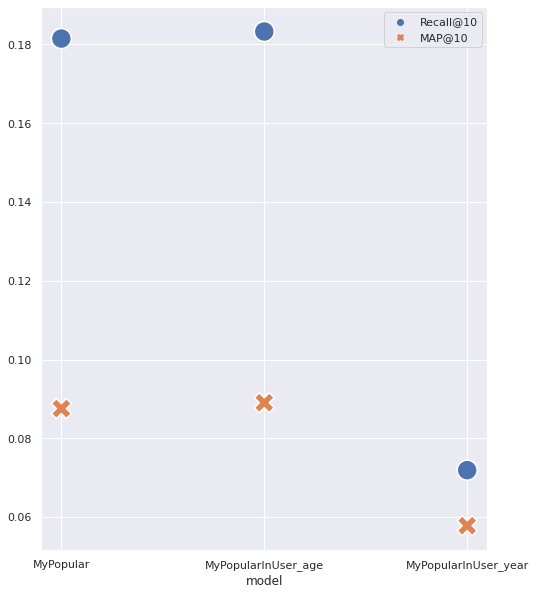

In [ ]:
plt.figure(figsize=(8, 10))
sns.scatterplot(data=pd.DataFrame(results).drop(columns='fold').groupby(['model'], sort=False).mean(), s=400)

Хоть и зависимость от пола "нечестная", но качество получше :)

# Submission

In [63]:
submission = pd.read_csv('sample_submission.csv')
train = interactions
test = submission
top_K=10

In [64]:
submission

,user_id,item_id
0,3,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
1,11,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
2,29,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
3,30,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
4,33,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
...,...,...
193108,1097527,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193109,1097537,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193110,1097538,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."
193111,1097544,"[9728, 15297, 10440, 14488, 13865, 12192, 341,..."


In [65]:
pop_model = PopularModel()
pop_model.fit(train)
recs_pop = pop_model.recommend(test['user_id'].unique(), k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()
recs_pop.to_csv('mypop_sub.csv', index=False)
recs_pop.head()

,user_id,item_id
0,3,"[10440, 15297, 9728, 13865, 4151, 3734, 2657, ..."
1,11,"[10440, 15297, 9728, 13865, 4151, 3734, 2657, ..."
2,29,"[10440, 15297, 9728, 13865, 4151, 3734, 2657, ..."
3,30,"[10440, 15297, 9728, 13865, 4151, 3734, 2657, ..."
4,33,"[10440, 15297, 9728, 13865, 4151, 3734, 2657, ..."


In [67]:
pop_model_catu = PopularUserCategoryModel(category_feature='sex',)
pop_model_catu.fit(train, users, nan_value='sex_unknown')
recs_popcatu = pop_model_catu.recommend(test['user_id'].unique(), k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()
recs_popcatu.to_csv('mypopcatu_sub.csv', index=False)
recs_popcatu.head()

,user_id,item_id
0,3,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
1,11,"[9728, 10440, 13865, 15297, 3734, 4151, 4880, ..."
2,29,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
3,30,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
4,33,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."


In [69]:
pop_model_catu_7d = PopularUserCategoryModel(category_feature='sex',period=pd.Timedelta(7, unit='d'))
pop_model_catu_7d.fit(train, users, nan_value='sex_unknown')
recs_popcatu_7d = pop_model_catu_7d.recommend(test['user_id'].unique(), k=top_K).groupby('user_id')['item_id'].apply(list).reset_index()
recs_popcatu_7d.to_csv('mypopcatu_7d_sub.csv', index=False)
recs_popcatu_7d.head()

,user_id,item_id
0,3,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
1,11,"[9728, 10440, 13865, 15297, 3734, 4151, 4880, ..."
2,29,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
3,30,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
4,33,"[10440, 15297, 2657, 4151, 13865, 9728, 3734, ..."
